In [1]:
import pandas, seaborn, scipy, numpy, matplotlib, sklearn, collections, itertools, math, functools, sys

%matplotlib inline
from matplotlib import pyplot
matplotlib.rc("savefig", dpi=800)
#matplotlib.rc("savefig", dpi=72)

from sklearn import preprocessing

# Constants
library_sizes = {
    'WGS': 3002000000,
    'WES': 50160183,
}
mhc_binding_threshold_affinity = 500

def bootstrap(values, statistic=numpy.mean, samples=5000):
    values = pandas.Series(values).dropna()
    if len(values) <= 1:
        return (numpy.nan, numpy.nan)
    values = [statistic(sklearn.utils.resample(values)) for i in range(samples)]
    return (numpy.percentile(values, 5), numpy.percentile(values, 95))

def round_to_n(x, n):
    return round(x, -int(math.floor(math.log10(x))) + (n - 1)) 

def mean_with_errorbars(values, decimals=0):
    pattern = "%%0.%df" % decimals
    bars = bootstrap(values)
    if numpy.nan in bars:
        return pattern % numpy.mean(values)
    if decimals == 0:
        bars = (round_to_n(bars[0], 2), round_to_n(bars[1], 2)) 
    return (pattern + " (" + pattern + " - " + pattern + ")") % ((numpy.mean(values),) + bars)

pandas.set_option('display.max_columns', 500)


def print_full(x):
    pandas.set_option('display.max_rows', len(x))
    print(x)
    pandas.reset_option('display.max_rows')

/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/tim/venvs/analysis-venv-2.7/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
model_inputs = {}

In [3]:
def canonicalize(x):
    (first, second) = x.split(">")
    assert len(first) == len(second) == 3
    assert first[0] == second[0]
    assert first[2] == second[2]
    return "%s[%s>%s]%s" % (first[0], first[1], second[1], first[2])

chicken_counts_df = pandas.read_csv("../data/chicken_mutation_counts_trinucleotide.csv", skiprows=4).dropna()
del chicken_counts_df["Clone"]
del chicken_counts_df["Total"]
chicken_counts_df.columns = ["Treatment"] + [canonicalize(x) for x in chicken_counts_df.columns[1:]]
context_columns = list(chicken_counts_df.columns[1:])
chicken_counts_df

for treatment in ['cisplatin', 'cyclophosphamide', 'etoposide']:
    combined_df = chicken_counts_df.ix[chicken_counts_df.Treatment.isin(["mock", treatment])].copy()
    treated_series = combined_df.Treatment == treatment
    del combined_df["Treatment"]

    data = {
        'num_sources': combined_df.shape[0],
        'num_contexts': combined_df.shape[1],
        'counts': combined_df.values.astype(int),
        'treated': treated_series.values.astype(int),
    }
    model_inputs['chicken %s' % treatment] = data
model_inputs.keys()

['chicken cyclophosphamide', 'chicken etoposide', 'chicken cisplatin']

In [4]:
worm_raw_df = pandas.read_csv("../data/c_elegans_substitutions.csv")
worm_raw_df["context_mutation_3p5p"] = (
    worm_raw_df.CONTEXT.str.slice(2, 3)
    + "[" + worm_raw_df.MUT_TYPE + "]"
    + worm_raw_df.CONTEXT.str.slice(4, 5))
worm_raw_df = worm_raw_df.ix[(worm_raw_df.Drug.isin(["None", "Cisplatin"]))]
worm_counts_df = (
    worm_raw_df.groupby(["Genotype", "Drug", "Concentration", "ID", "context_mutation_3p5p"])
    .Genotype.count().unstack('context_mutation_3p5p')
    .fillna(0))
assert all(c in context_columns for c in worm_counts_df.columns)
worm_counts_df = worm_counts_df.T.ix[context_columns].T.fillna(0)
worm_counts_df = worm_counts_df.reset_index()
worm_counts_df["treated"] = worm_counts_df.Concentration > 0
treated_genotypes = worm_counts_df.groupby(["Genotype"]).treated.nunique() > 1
worm_counts_df = worm_counts_df.ix[worm_counts_df.Genotype.isin(
        list(treated_genotypes.index[treated_genotypes]))]
worm_counts_df["Treatment"] = [
    "mock" if not row.treated else "%s" % (row.Drug,)
    for (i, row) in worm_counts_df.iterrows()
]
worm_counts_df = worm_counts_df[["Genotype", "Treatment"] + context_columns]
worm_counts_df

context_mutation_3p5p,Genotype,Treatment,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,N2,Cisplatin,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,N2,Cisplatin,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,N2,Cisplatin,0,0,0,0,0,4,0,2,0,1,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,N2,Cisplatin,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,N2,Cisplatin,0,0,0,1,1,3,0,0,0,0,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,N2,mock,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
6,N2,mock,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
7,N2,mock,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,N2,mock,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,N2,mock,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [5]:
for (genotype, sub_worm_df) in worm_counts_df.groupby("Genotype"):
    sub_worm_df = sub_worm_df.copy()
    del sub_worm_df["Genotype"]
    for treatment in ["Cisplatin"]:
        combined_df = sub_worm_df.ix[sub_worm_df.Treatment.isin(["mock", treatment])].copy()
        treated_series = combined_df.Treatment == treatment
        del combined_df["Treatment"]

        data = {
            'num_sources': combined_df.shape[0],
            'num_contexts': combined_df.shape[1],
            'counts': combined_df.values.astype(int),
            'treated': treated_series.values.astype(int),
        }
        model_inputs['worm %s %s' % (genotype, treatment)] = data
model_inputs.keys()

['worm polq-1 Cisplatin',
 'worm slx-1 Cisplatin',
 'worm fan-1 Cisplatin',
 'chicken etoposide',
 'worm fcd-2 Cisplatin',
 'worm lig-4; fcd-2 Cisplatin',
 'chicken cyclophosphamide',
 'worm mus-81 Cisplatin',
 'worm lig-4 Cisplatin',
 'worm xpf-1 Cisplatin',
 'worm N2 Cisplatin',
 'chicken cisplatin']

In [6]:
import pystan, time
FIT_CACHE={}
def run_stan(model_code, *args, **kwargs):
    kwargs = dict(kwargs)
    kwargs['model_code'] = model_code
    if 'n_jobs' not in kwargs:
        kwargs['n_jobs'] = -1
    if model_code in FIT_CACHE:
        print("Reusing fit.")
        kwargs['fit'] = FIT_CACHE[model_code]
    else:
        print("NOT reusing fit.")
    start = time.time()
    FIT_CACHE[model_code] = pystan.stan(*args, **kwargs)
    print("Ran in %0.3f sec." % (time.time() - start))
    return FIT_CACHE[model_code]



In [7]:
# stan model
model1 = """
data {
    // Data sizes
    int<lower=0> num_sources;
    int<lower=0> num_contexts;

    // Data
    int<lower=0> counts[num_sources, num_contexts];
    int<lower=0,upper=1> treated[num_sources];
}
parameters {
    vector<lower=0>[num_contexts] untreated_rates;
    vector<lower=0>[num_contexts] treated_rates;
}
model {
    for (i in 1:num_sources) {
        counts[i] ~ poisson(untreated_rates + treated[i] * treated_rates);
    }
}
""".strip()

def init(data):
    return {
        'untreated_rates': numpy.ones(len(context_columns), dtype=int),
        'treated_rates': numpy.ones(len(context_columns), dtype=int),
    }

for (i, line) in enumerate(model1.split("\n")):
    print("%3d %s" % (i + 1, line))

def print_dict(d):
    for key in [key for key in d if not isinstance(d[key], numpy.ndarray)]:
        print("%s: %s" % (key, d[key]))
    for key in [key for key in d if isinstance(d[key], numpy.ndarray)]:
        print("%s: %s mean=%s std=%s" % (key,  d[key].shape, d[key].mean(), d[key].std()))

fit_results = {}
for (label, data) in model_inputs.items():
    print("+" * 40)
    print("RUNNING MODEL FOR: %s" % label)
    print("")
    print("*" * 40)
    print("DATA")
    print_dict(data)
    print("")

    print("*" * 40)
    print("INITIAL VALUES")
    print_dict(init(data))
    sys.stdout.flush()
    
    fit_results[label] = run_stan(model_code=model1, data=data, init=lambda: init(data), iter=2000, chains=2)
    print("Done with fit.")
print("DONE")


  1 data {
  2     // Data sizes
  3     int<lower=0> num_sources;
  4     int<lower=0> num_contexts;
  5 
  6     // Data
  7     int<lower=0> counts[num_sources, num_contexts];
  8     int<lower=0,upper=1> treated[num_sources];
  9 }
 10 parameters {
 11     vector<lower=0>[num_contexts] untreated_rates;
 12     vector<lower=0>[num_contexts] treated_rates;
 13 }
 14 model {
 15     for (i in 1:num_sources) {
 16         counts[i] ~ poisson(untreated_rates + treated[i] * treated_rates);
 17     }
 18 }
++++++++++++++++++++++++++++++++++++++++
RUNNING MODEL FOR: worm polq-1 Cisplatin

****************************************
DATA
num_sources: 8
num_contexts: 96
counts: (8, 96) mean=0.08203125 std=0.28829607008
treated: (8,) mean=0.75 std=0.433012701892

****************************************
INITIAL VALUES
treated_rates: (96,) mean=1.0 std=0.0
untreated_rates: (96,) mean=1.0 std=0.0
NOT reusing fit.
Ran in 43.817 sec.
Done with fit.
++++++++++++++++++++++++++++++++++++++++
RUNNING MO

In [8]:
fit_counts_means = []
fit_counts_means_index = []
for (label, results) in fit_results.items():
    fit_counts_means_index.append(label)
    fit_counts_means.append(results.extract()['treated_rates'].mean(0))

mean_rates_df = pandas.DataFrame(fit_counts_means, index=fit_counts_means_index, columns=context_columns)
mean_rates_df

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
worm polq-1 Cisplatin,0.363366,0.258445,0.361962,0.165652,0.168375,0.598835,0.171291,0.720912,0.261117,0.348240,0.167597,0.163022,0.168492,0.166221,0.261311,0.264857,0.162680,0.260688,0.165943,0.265257,0.164306,0.169196,0.171138,0.166245,0.258642,0.162601,0.162839,0.162473,0.160086,0.168408,0.261203,0.164716,0.164837,0.165768,0.168889,0.164670,0.163381,0.164566,0.364968,0.236504,0.164734,0.261631,0.263244,0.165728,0.264082,0.253274,0.170785,0.162376,0.365707,0.170937,0.260337,0.262741,0.260250,0.168915,0.168542,0.173116,0.257263,0.167190,0.166412,0.169105,0.260997,0.257857,0.164693,0.167336,0.468048,0.164259,0.169835,0.170079,0.162770,0.260165,0.170068,0.163207,0.166133,0.171477,0.169845,0.368784,0.263659,0.260098,0.166986,0.162324,0.168056,0.168553,0.263428,0.261818,0.164675,0.168775,0.165892,0.169534,0.163315,0.161213,0.303157,0.261420,0.165033,0.266749,0.163550,0.255358
worm slx-1 Cisplatin,0.268742,0.261006,0.164122,0.166120,0.267404,0.914228,0.162234,1.032960,0.165709,0.263479,0.165578,0.494474,0.167485,0.273060,0.169694,0.165370,0.172660,0.170035,0.164994,0.171006,0.159876,0.164384,0.163836,0.167026,0.263230,0.169544,0.168014,0.164709,0.165591,0.166651,0.166521,0.263946,0.164156,0.165416,0.170756,0.167879,0.169146,0.268428,0.163504,0.271452,0.165381,0.169702,0.163812,0.377651,0.165584,0.157571,0.167924,0.164023,0.261574,0.168380,0.271177,0.168827,0.161860,0.386367,0.169080,0.162261,0.172867,0.166205,0.167439,0.163529,0.162464,0.270063,0.263745,0.172122,0.167147,0.168208,0.171414,0.380131,0.173135,0.269811,0.167270,0.261903,0.161971,0.169390,0.169864,0.269524,0.265245,0.165279,0.167357,0.768731,0.172291,0.168320,0.172272,0.164348,0.165900,0.162466,0.169009,0.169145,0.162123,0.166485,0.162470,0.168542,0.164957,0.160342,0.169515,0.167066
worm fan-1 Cisplatin,0.259976,0.159879,0.166124,0.166925,0.164793,0.721458,0.166803,0.592214,0.254913,0.298321,0.262586,0.726223,0.270255,0.168028,0.171177,0.166558,0.163007,0.168235,0.163762,0.161387,0.171381,0.263001,0.171968,0.164122,0.167717,0.176862,0.168514,0.170169,0.165837,0.165103,0.169134,0.173209,0.165578,0.166887,0.162709,0.163748,0.165907,0.168353,0.163004,0.262513,0.254090,0.161207,0.172140,0.172160,0.263134,0.172922,0.165296,0.366874,0.170858,0.167290,0.168261,0.259122,0.267009,0.163027,0.168718,0.258286,0.165959,0.166672,0.164530,0.258784,0.382137,0.163347,0.164480,0.165396,0.167980,0.165025,0.162615,0.159447,0.238597,0.168953,0.163382,0.568768,0.167458,0.171977,0.159673,0.166915,0.162387,0.253799,0.167865,0.264343,0.167185,0.167371,0.166175,0.169368,0.163446,0.166737,0.167112,0.166581,0.170753,0.165783,0.164776,0.166623,0.163302,0.165558,0.168871,0.255468
chicken etoposide,1.378578,0.840336,0.506545,0.625482,1.106744,0.337071,0.570533,0.710087,1.563145,0.546014,0.338482,0.988702,1.110564,1.358504,0.572871,1.299614,1.755742,0.339017,0.549589,0.874051,0.567236,0.332746,0.563654,0.516379,0.729773,0.340196,0.572782,0.729060,0.467780,0.332819,0.325141,0.714188,0.625948,1.362219,2.157668,0.809184,1.287389,0.426190,2.037035,0.654526,1.492727,1.340848,2.593094,2.118418,0.422786,0.776520,0.732332,0.722881,0.734963,0.665547,0.333037,0.476654,0.328449,1.235324,0.772720,1.484867,0.727581,0.868944,0.729439,1.365045,0.601800,0.831331

In [9]:
chicken_trinucleotide_frequencies = pandas.read_csv("../data/chicken_trinucleotide_frequencies.csv", skiprows=4, index_col=0)
chicken_trinucleotide_frequencies = chicken_trinucleotide_frequencies[list(chicken_trinucleotide_frequencies.columns)[:3]].dropna()
chicken_trinucleotide_frequencies

c_elegans_trinucleotide_frequencies = pandas.read_csv("../data/c_elegans.trinucleotides.csv", index_col='context')
assert set(c_elegans_trinucleotide_frequencies.index) == set(chicken_trinucleotide_frequencies.index)
c_elegans_trinucleotide_frequencies = c_elegans_trinucleotide_frequencies.ix[chicken_trinucleotide_frequencies.index]
assert list(c_elegans_trinucleotide_frequencies.index) == list(chicken_trinucleotide_frequencies.index)
c_elegans_trinucleotide_frequencies
c_elegans_trinucleotide_frequencies.columns = ["C elegans"]

trinucleotide_frequencies = pandas.merge(
    chicken_trinucleotide_frequencies,
    c_elegans_trinucleotide_frequencies,
    left_index=True,
    right_index=True)
del trinucleotide_frequencies["Human/chicken ratio"]
trinucleotide_frequencies.columns = trinucleotide_frequencies.columns.map({
        "Gallus gallus": "chicken",
        "Homo sapiens": "human",
        "C elegans": "worm",
    }.get)
trinucleotide_frequencies

,chicken,human,worm
ACA,0.043165,0.040337,0.036124
ACC,0.021226,0.023258,0.017362
ACG,0.006771,0.005026,0.016543
ACT,0.033155,0.032173,0.030348
CCA,0.033537,0.036888,0.025531
CCC,0.023988,0.026295,0.011433
CCG,0.005774,0.005522,0.013242
CCT,0.033154,0.035518,0.017187
GCA,0.037486,0.028803,0.022975
GCC,0.020606,0.023797,0.013029


In [10]:
normalization_trinucleotides = [
    x[0] + x[2] + x[-1]
    for x in context_columns
]
normalization_trinucleotides

def human_normalize_row(label, row):
    species = label.split()[0]
    occurrences = trinucleotide_frequencies[species].ix[normalization_trinucleotides]
    human_occurrences = trinucleotide_frequencies["human"].ix[normalization_trinucleotides]
    human_unnormalized = (row.values / occurrences.values) * human_occurrences.values
    return human_unnormalized / human_unnormalized.sum()

human_normalized_rates = pandas.DataFrame([
        human_normalize_row(i, row)
        for (i, row) in mean_rates_df.iterrows()
    ], index=mean_rates_df.index, columns=mean_rates_df.columns)
human_normalized_rates

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
worm polq-1 Cisplatin,0.017243,0.014713,0.004673,0.007463,0.010338,0.058531,0.003036,0.063315,0.013912,0.027030,0.003131,0.009553,0.006341,0.008546,0.002211,0.013255,0.007720,0.014841,0.002143,0.011951,0.010088,0.016537,0.003033,0.014601,0.013780,0.012621,0.003042,0.009521,0.006025,0.008658,0.002210,0.008243,0.007822,0.009437,0.002181,0.007419,0.010032,0.016085,0.006468,0.020771,0.008777,0.020308,0.004917,0.009711,0.009939,0.013021,0.001445,0.008126,0.015473,0.005912,0.011957,0.007766,0.013680,0.009844,0.012008,0.008136,0.011041,0.007398,0.009397,0.005606,0.010826,0.007983,0.005473,0.005242,0.019803,0.005681,0.007801,0.005027,0.008556,0.015161,0.012117,0.007670,0.007130,0.007588,0.009591,0.012226,0.010936,0.008052,0.005549,0.005085,0.007110,0.005830,0.012099,0.007739,0.008656,0.009835,0.011820,0.007967,0.007009,0.007134,0.017119,0.008666,0.006845,0.008258,0.005435,0.007999
worm slx-1 Cisplatin,0.012151,0.014158,0.002019,0.007131,0.015644,0.085138,0.002739,0.086437,0.008412,0.019485,0.002947,0.027607,0.006006,0.013376,0.001368,0.007885,0.007806,0.009223,0.002030,0.007341,0.009353,0.015308,0.002766,0.013977,0.013362,0.012539,0.002990,0.009196,0.005938,0.008163,0.001342,0.012586,0.007422,0.008973,0.002101,0.007207,0.009895,0.024997,0.002761,0.022715,0.008395,0.012550,0.002916,0.021085,0.005938,0.007719,0.001354,0.007821,0.010544,0.005549,0.011867,0.004755,0.008106,0.021453,0.011478,0.007266,0.007069,0.007007,0.009008,0.005165,0.006421,0.007966,0.008351,0.005137,0.006738,0.005543,0.007501,0.010705,0.008671,0.014981,0.011355,0.011727,0.006623,0.007142,0.009139,0.008513,0.010483,0.004875,0.005299,0.022943,0.006945,0.005547,0.007539,0.004628,0.008309,0.009021,0.011473,0.007574,0.006629,0.007019,0.008741,0.005324,0.006519,0.004729,0.005367,0.004986
worm fan-1 Cisplatin,0.012589,0.009288,0.002189,0.007675,0.010325,0.071958,0.003017,0.053076,0.013859,0.023629,0.005005,0.043426,0.010379,0.008815,0.001478,0.008506,0.007893,0.009774,0.002158,0.007420,0.010738,0.026232,0.003110,0.014709,0.009118,0.014009,0.003212,0.010176,0.006369,0.008662,0.001460,0.008846,0.008018,0.009695,0.002144,0.007529,0.010395,0.016792,0.002948,0.023527,0.013814,0.012769,0.003281,0.010295,0.010106,0.009072,0.001427,0.018736,0.007377,0.005905,0.007886,0.007816,0.014322,0.009695,0.012267,0.012387,0.007268,0.007526,0.009481,0.008754,0.016175,0.005160,0.005578,0.005287,0.007252,0.005825,0.007622,0.004809,0.012798,0.010047,0.011879,0.027277,0.007334,0.007766,0.009201,0.005647,0.006874,0.008018,0.005693,0.008450,0.007218,0.005908,0.007789,0.005109,0.008767,0.009915,0.012150,0.007989,0.007478,0.007486,0.009495,0.005637,0.006912,0.005230,0.005727,0.008166
chicken etoposide,0.015258,0.010906,0.004453,0.007189,0.014418,0.004376,0.006463,0.009010,0.014226,0.007469,0.003483,0.009394,0.012948,0.016216,0.006733,0.015390,0.019433,0.004400,0.004832,0.010046,0.007390,0.004320,0.006385,0.006552,0.006642,0.004653,0.005894,0.006927,0.005454,0.003973,0.003821,0.008457,0.006928,0.017680,0.018969,0.009301,0.016772,0.005533,0.023074,0.008305,0.013585,0.018341,0.026681,0.020128,0.004929,0.009269,0.008607,0.008560,0.010425,0.007882,0.003925,0.006315,0.004336,0.015556,0.007720,0.016489,0.008309,0.010419,0.008367,0.015163,0.007775,0.009225

In [11]:
def canonicalize_label(label):
    pieces = label.replace("N2", "wildtype").split()
    pieces[0] = {'worm': "C. Elegans", "chicken": "Gallus gallus"}[pieces[0]]
    return pieces[-1][0].upper() + pieces[-1][1:].lower() + ": " + " ".join(pieces[:-1])

human_normalized_rates_canonicalized = human_normalized_rates.copy()
human_normalized_rates_canonicalized.index = [
    canonicalize_label(x) for x in human_normalized_rates_canonicalized.index
]
human_normalized_rates_canonicalized = human_normalized_rates_canonicalized.ix[
    sorted(human_normalized_rates_canonicalized.index, key=lambda x: ('gallus' not in x, 'wildtype' not in x, x))
]
human_normalized_rates_canonicalized

,A[C>A]A,A[C>A]C,A[C>A]G,A[C>A]T,C[C>A]A,C[C>A]C,C[C>A]G,C[C>A]T,G[C>A]A,G[C>A]C,G[C>A]G,G[C>A]T,T[C>A]A,T[C>A]C,T[C>A]G,T[C>A]T,A[C>G]A,A[C>G]C,A[C>G]G,A[C>G]T,C[C>G]A,C[C>G]C,C[C>G]G,C[C>G]T,G[C>G]A,G[C>G]C,G[C>G]G,G[C>G]T,T[C>G]A,T[C>G]C,T[C>G]G,T[C>G]T,A[C>T]A,A[C>T]C,A[C>T]G,A[C>T]T,C[C>T]A,C[C>T]C,C[C>T]G,C[C>T]T,G[C>T]A,G[C>T]C,G[C>T]G,G[C>T]T,T[C>T]A,T[C>T]C,T[C>T]G,T[C>T]T,A[T>A]A,A[T>A]C,A[T>A]G,A[T>A]T,C[T>A]A,C[T>A]C,C[T>A]G,C[T>A]T,G[T>A]A,G[T>A]C,G[T>A]G,G[T>A]T,T[T>A]A,T[T>A]C,T[T>A]G,T[T>A]T,A[T>C]A,A[T>C]C,A[T>C]G,A[T>C]T,C[T>C]A,C[T>C]C,C[T>C]G,C[T>C]T,G[T>C]A,G[T>C]C,G[T>C]G,G[T>C]T,T[T>C]A,T[T>C]C,T[T>C]G,T[T>C]T,A[T>G]A,A[T>G]C,A[T>G]G,A[T>G]T,C[T>G]A,C[T>G]C,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Cisplatin: Gallus gallus,0.005651,0.103384,0.000470,0.023226,0.021821,0.064668,0.001023,0.021616,0.008571,0.144042,0.001953,0.022747,0.006766,0.128060,0.001047,0.040139,0.002740,0.002237,0.000318,0.003925,0.004692,0.003268,0.000984,0.002955,0.004351,0.010295,0.000632,0.001579,0.003242,0.004258,0.001805,0.005939,0.001805,0.005785,0.000665,0.001810,0.005345,0.006468,0.001170,0.006637,0.004780,0.007475,0.001613,0.007310,0.002930,0.010119,0.001282,0.012658,0.006693,0.042448,0.004258,0.003658,0.022231,0.015756,0.016801,0.014491,0.001487,0.015901,0.001206,0.003054,0.005884,0.013039,0.004790,0.004832,0.002121,0.004692,0.001063,0.002082,0.003115,0.005347,0.006241,0.006960,0.001655,0.002213,0.000767,0.002210,0.001703,0.003301,0.001908,0.002283,0.001822,0.001066,0.005666,0.000933,0.005225,0.001950,0.011103,0.002532,0.000403,0.001807,0.005333,0.001934,0.001342,0.000661,0.005493,0.002280
Cyclophosphamide: Gallus gallus,0.005414,0.006806,0.001082,0.008658,0.004133,0.003529,0.002358,0.007098,0.002093,0.002090,0.002141,0.003424,0.004769,0.003836,0.001415,0.007460,0.003130,0.002275,0.001054,0.003545,0.002706,0.001655,0.001371,0.001576,0.002427,0.001625,0.001242,0.006507,0.002075,0.007654,0.001455,0.003077,0.010705,0.026161,0.002353,0.019296,0.015001,0.038201,0.007088,0.019647,0.005971,0.026140,0.003780,0.014970,0.004756,0.015947,0.003103,0.027766,0.013000,0.008476,0.017660,0.031370,0.017361,0.026689,0.036166,0.094296,0.017292,0.004823,0.011731,0.026455,0.031452,0.009780,0.019459,0.066230,0.003487,0.009073,0.009777,0.009925,0.004577,0.004624,0.003941,0.014574,0.004454,0.005172,0.003632,0.018017,0.004612,0.002932,0.005414,0.014881,0.003118,0.003709,0.004115,0.004208,0.014824,0.003801,0.005477,0.020812,0.003456,0.002469,0.002365,0.002623,0.005749,0.007069,0.002402,0.011909
Etoposide: Gallus gallus,0.015258,0.010906,0.004453,0.007189,0.014418,0.004376,0.006463,0.009010,0.014226,0.007469,0.003483,0.009394,0.012948,0.016216,0.006733,0.015390,0.019433,0.004400,0.004832,0.010046,0.007390,0.004320,0.006385,0.006552,0.006642,0.004653,0.005894,0.006927,0.005454,0.003973,0.003821,0.008457,0.006928,0.017680,0.018969,0.009301,0.016772,0.005533,0.023074,0.008305,0.013585,0.018341,0.026681,0.020128,0.004929,0.009269,0.008607,0.008560,0.010425,0.007882,0.003925,0.006315,0.004336,0.015556,0.007720,0.016489,0.008309,0.010419,0.008367,0.015163,0.007775,0.009225,0.005922,0.011159,0.011658,0.021311,0.019367,0.043535,0.012896,0.009644,0.006584,0.032372,0.012733,0.009348,0.012729,0.007790,0.004231,0.007979,0.003941,0.021486,0.004806,0.003879,0.006138,0.011315,0.011266,0.007239,0.007237,0.005558,0.006541,0.006972,0.006628,0.007326,0.020007,0.003658,0.009796,0.011268
Cisplatin: C. Elegans wildtype,0.007270,0.008788,0.001982,0.010452,0.014231,0.138788,0.002731,0.039056,0.008266,0.024862,0.002823,0.029921,0.014070,0.022217,0.003174,0.007754,0.007483,0.008499,0.002008,0.011980,0.009225,0.015258,0.002595,0.013480,0.008032,0.018053,0.002931,0.008977,0.005894,0.007984,0.002181,0.007580,0.007470,0.014393,0.002031,0.006809,0.009140,0.015072,0.002640,0.013907,0.008468,0.017089,0.002889,0.009272,0.007772,0.017200,0.001318,0.007680,0.010167,0.005410,0.007112,0.006974,0.008129,0.008834,0.011129,0.024222,0.011013,0.006863,0.00

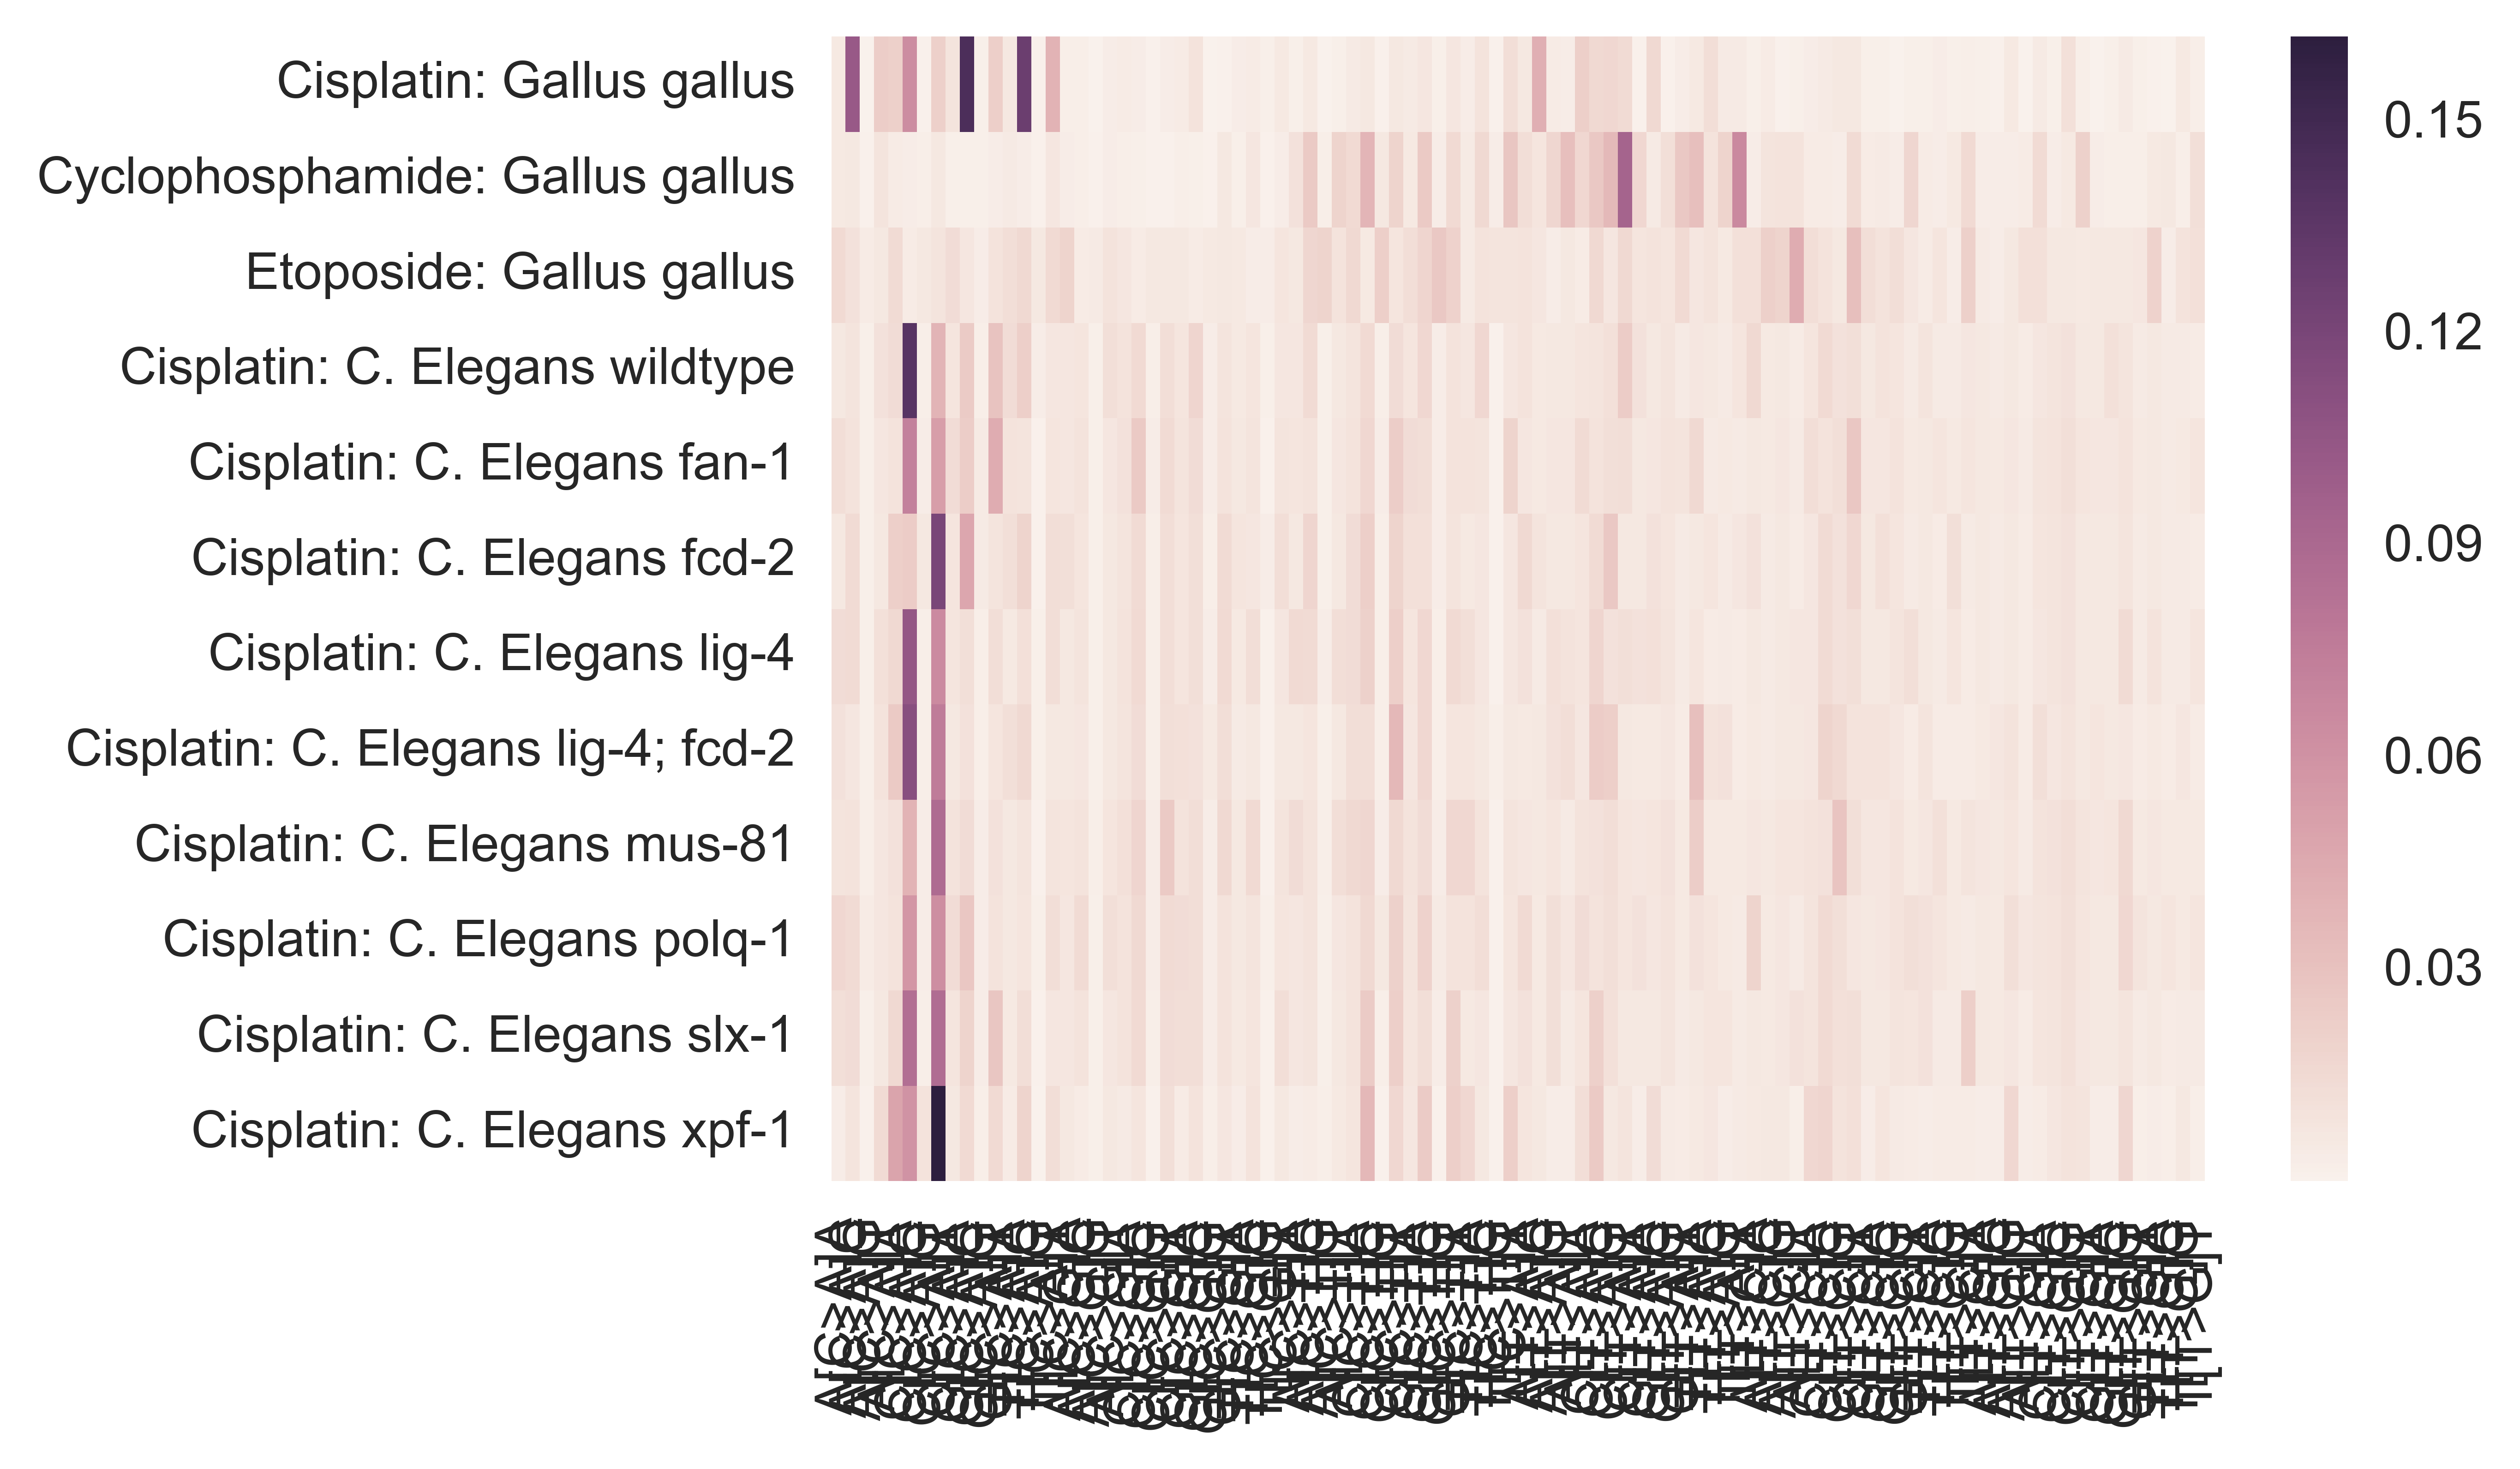

In [12]:
seaborn.heatmap(human_normalized_rates_canonicalized)

In [13]:
cosmic_signatures = pandas.read_table("../data/signatures_probabilities.txt", index_col="Somatic Mutation Type")
del cosmic_signatures["Substitution Type"]
del cosmic_signatures["Trinucleotide"]
cosmic_signatures = cosmic_signatures.dropna(1)
cosmic_signatures

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25,Signature 26,Signature 27,Signature 28,Signature 29,Signature 30
Somatic Mutation Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,0.011098,6.827082e-04,0.022172,0.0365,0.014942,0.0017,0.0004,0.036718,0.0120,0.0007,0.0002,0.0077,3.347572e-04,0.0001,0.0013,0.0161,0.001832,5.053642e-02,0.0107,1.179962e-03,0.0001,0.001504,0.000453,0.028646,0.009897,2.039773e-03,0.005206,0.001397,0.069982,0.000000
A[C>A]C,0.009149,6.191072e-04,0.017872,0.0309,0.008961,0.0028,0.0005,0.033246,0.0067,0.0010,0.0010,0.0047,6.487361e-04,0.0042,0.0040,0.0097,0.000342,1.093982e-02,0.0074,2.211505e-03,0.0007,0.002451,0.000367,0.020215,0.006999,1.487162e-03,0.004738,0.000917,0.055152,0.000000
A[C>A]G,0.001490,9.927896e-05,0.002138,0.0183,0.002208,0.0005,0.0000,0.002525,0.0005,0.0003,0.0000,0.0017,3.814459e-05,0.0005,0.0000,0.0022,0.000002,2.288073e-03,0.0005,1.616910e-07,0.0000,0.000000,0.000000,0.020479,0.001448,2.839456e-04,0.000783,0.000000,0.017847,0.001967
A[C>A]T,0.006234,3.238914e-04,0.016265,0.0243,0.009207,0.0019,0.0004,0.033599,0.0068,0.0092,0.0002,0.0046,8.466585e-04,0.0296,0.0057,0.0088,0.003180,1.942409e-02,0.0074,3.008010e-03,0.0006,0.000922,0.000000,0.024600,0.004967,5.978656e-04,0.002718,0.000513,0.026805,0.000000
A[C>G]A,0.001801,2.634810e-04,0.024003,0.0097,0.011671,0.0013,0.0000,0.008357,0.0048,0.0005,0.0007,0.0031,3.775165e-03,0.0001,0.0011,0.0048,0.001662,1.516888e-03,0.0058,6.970411e-04,0.0005,0.000528,0.000000,0.011993,0.008033,1.272881e-03,0.001324,0.000255,0.009302,0.000000
A[C>G]C,0.002581,2.698660e-04,0.012160,0.0054,0.007292,0.0012,0.0000,0.004306,0.0023,0.0003,0.0003,0.0015,9.208248e-04,0.0000,0.0001,0.0024,0.001627,2.498785e-03,0.0019,2.059310e-03,0.0008,0.000000,0.000000,0.008425,0.001636,1.528195e-03,0.001771,0.000269,0.003479,0.000000
A[C>G]G,0.000593,2.192339e-04,0.005275,0.0031,0.002304,0.0000,0.0000,0.000584,0.0000,0.0000,0.0000,0.0000,1.989049e-05,0.0000,0.0006,0.0000,0.000026,2.614509e-03,0.0000,1.273496e-05,0.0000,0.000000,0.000000,0.000000,0.000000,3.072463e-04,0.000000,0.000000,0.000154,0.004820
A[C>G]T,0.002964,6.109735e-04,0.023278,0.0054,0.011696,0.0018,0.0001,0.008635,0.0038,0.0002,0.0009,0.0025,3.860632e-03,0.0001,0.0010,0.0073,0.001329,3.983011e-03,0.0072,8.485871e-04,0.0018,0.000299,0.000000,0.003881,0.003428,2.498252e-03,0.001323,0.000308,0.003977,0.000000
A[C>T]A,0.029515,7.441557e-03,0.017872,0.0120,0.021839,0.0312,0.0000,0.018067,0.0093,0.0000,0.0225,0.0121,1.480181e-03,0.0293,0.0117,0.0135,0.009350,3.825624e-03,0.0221,3.285805e-02,0.0051,0.003113,0.019767,0.006316,0.020988,5.907232e-03,0.013723,0.005434,0.005197,0.065119


In [15]:
all_signatures = cosmic_signatures.copy()
for col in human_normalized_rates_canonicalized.index:
    all_signatures[col] = human_normalized_rates_canonicalized.ix[col]
all_signatures.T.to_csv("../data/all_signatures.csv")
all_signatures
    

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25,Signature 26,Signature 27,Signature 28,Signature 29,Signature 30,Cisplatin: Gallus gallus,Cyclophosphamide: Gallus gallus,Etoposide: Gallus gallus,Cisplatin: C. Elegans wildtype,Cisplatin: C. Elegans fan-1,Cisplatin: C. Elegans fcd-2,Cisplatin: C. Elegans lig-4,Cisplatin: C. Elegans lig-4; fcd-2,Cisplatin: C. Elegans mus-81,Cisplatin: C. Elegans polq-1,Cisplatin: C. Elegans slx-1,Cisplatin: C. Elegans xpf-1
Somatic Mutation Type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A[C>A]A,0.011098,6.827082e-04,0.022172,0.0365,0.014942,0.0017,0.0004,0.036718,0.0120,0.0007,0.0002,0.0077,3.347572e-04,0.0001,0.0013,0.0161,0.001832,5.053642e-02,0.0107,1.179962e-03,0.0001,0.001504,0.000453,0.028646,0.009897,2.039773e-03,0.005206,0.001397,0.069982,0.000000,0.005651,0.005414,0.015258,0.007270,0.012589,0.007211,0.013727,0.010548,0.008637,0.017243,0.012151,0.004080
A[C>A]C,0.009149,6.191072e-04,0.017872,0.0309,0.008961,0.0028,0.0005,0.033246,0.0067,0.0010,0.0010,0.0047,6.487361e-04,0.0042,0.0040,0.0097,0.000342,1.093982e-02,0.0074,2.211505e-03,0.0007,0.002451,0.000367,0.020215,0.006999,1.487162e-03,0.004738,0.000917,0.055152,0.000000,0.103384,0.006806,0.010906,0.008788,0.009288,0.014533,0.014442,0.007777,0.010169,0.014713,0.014158,0.009058
A[C>A]G,0.001490,9.927896e-05,0.002138,0.0183,0.002208,0.0005,0.0000,0.002525,0.0005,0.0003,0.0000,0.0017,3.814459e-05,0.0005,0.0000,0.0022,0.000002,2.288073e-03,0.0005,1.616910e-07,0.0000,0.000000,0.000000,0.020479,0.001448,2.839456e-04,0.000783,0.000000,0.017847,0.001967,0.000470,0.001082,0.004453,0.001982,0.002189,0.001994,0.002041,0.001745,0.002294,0.004673,0.002019,0.001101
A[C>A]T,0.006234,3.238914e-04,0.016265,0.0243,0.009207,0.0019,0.0004,0.033599,0.0068,0.0092,0.0002,0.0046,8.466585e-04,0.0296,0.0057,0.0088,0.003180,1.942409e-02,0.0074,3.008010e-03,0.0006,0.000922,0.000000,0.024600,0.004967,5.978656e-04,0.002718,0.000513,0.026805,0.000000,0.023226,0.008658,0.007189,0.010452,0.007675,0.007051,0.011421,0.009839,0.007808,0.007463,0.007131,0.014444
A[C>G]A,0.001801,2.634810e-04,0.024003,0.0097,0.011671,0.0013,0.0000,0.008357,0.0048,0.0005,0.0007,0.0031,3.775165e-03,0.0001,0.0011,0.0048,0.001662,1.516888e-03,0.0058,6.970411e-04,0.0005,0.000528,0.000000,0.011993,0.008033,1.272881e-03,0.001324,0.000255,0.009302,0.000000,0.002740,0.003130,0.019433,0.007483,0.007893,0.012035,0.007178,0.006642,0.008388,0.007720,0.007806,0.006261
A[C>G]C,0.002581,2.698660e-04,0.012160,0.0054,0.007292,0.0012,0.0000,0.004306,0.0023,0.0003,0.0003,0.0015,9.208248e-04,0.0000,0.0001,0.0024,0.001627,2.498785e-03,0.0019,2.059310e-03,0.0008,0.000000,0.000000,0.008425,0.001636,1.528195e-03,0.001771,0.000269,0.003479,0.000000,0.002237,0.002275,0.004400,0.008499,0.009774,0.008508,0.008896,0.007727,0.009845,0.014841,0.009223,0.004701
A[C>G]G,0.000593,2.192339e-04,0.005275,0.0031,0.002304,0.0000,0.0000,0.000584,0.0000,0.0000,0.0000,0.0000,1.989049e-05,0.0000,0.0006,0.0000,0.000026,2.614509e-03,0.0000,1.273496e-05,0.0000,0.000000,0.000000,0.000000,0.000000,3.072463e-04,0.000000,0.000000,0.000154,0.004820,0.000318,0.001054,0.004832,0.002008,0.002158,0.001978,0.001972,0.001759,0.002270,0.002143,0.002030,0.001690
A[C>G]T,0.002964,6.109735e-04,0.023278,0.0054,0.011696,0.0018,0.0001,0.008635,0.0038,0.0002,0.0009,0.0025,3.860632e-03,0.0001,0.0010,0.0073,0.001329,3.983011e-03,0.0072,8.485871e-04,0.0018,0.000299,0.000000,0.003881,0.003428,2.498252e-03,0.001323,0.000308,0.003977,0.000000,0.003925,0.003545,0.010046,0.011980,0.007420,0.006884,0.006787,0.006212,0.008088,0.011951,0.007341,0.006130
A[C>T]A,0.029515,7.441557e-03,0.017872,0.0120,0.021839,0.0312,0.0000,0.018067,0.0093,0.0000,0.0225,0.0121,1.480181e-03,0.0293,0.0117,0.0135,0.009350,3.8